In [12]:
import sys
import pandas as pd
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
from stattool.empirical_design import check_aa
from stattool.plot_tool import plot_cdf
from scipy.stats import norm, ttest_ind
from stattool import deltamethod
from stattool.theoretical_design import get_parameter_size

In [13]:
df = pd.read_parquet('../dataset/prepared_trips.parquet')

# Primary analysis

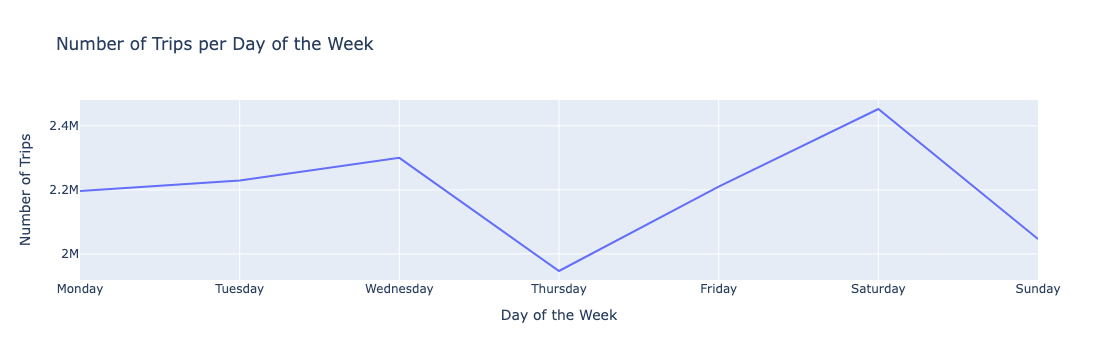

In [14]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
trips_per_day = df['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

fig = px.line(
    x=trips_per_day.index,
    y=trips_per_day.values,
    labels={'x': 'Day of the Week', 'y': 'Number of Trips'},
    title='Number of Trips per Day of the Week'
)
fig.show()

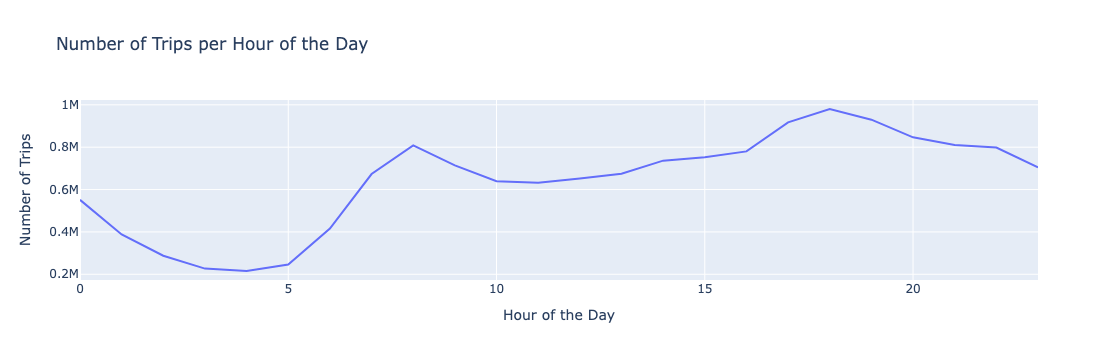

In [15]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
trips_per_hour = df['hour_of_day'].value_counts().sort_index()

fig = px.line(
    x=trips_per_hour.index,
    y=trips_per_hour.values,
    labels={'x': 'Hour of the Day', 'y': 'Number of Trips'},
    title='Number of Trips per Hour of the Day'
)
fig.show()



office workers patterns 
lets check if it differs by day 

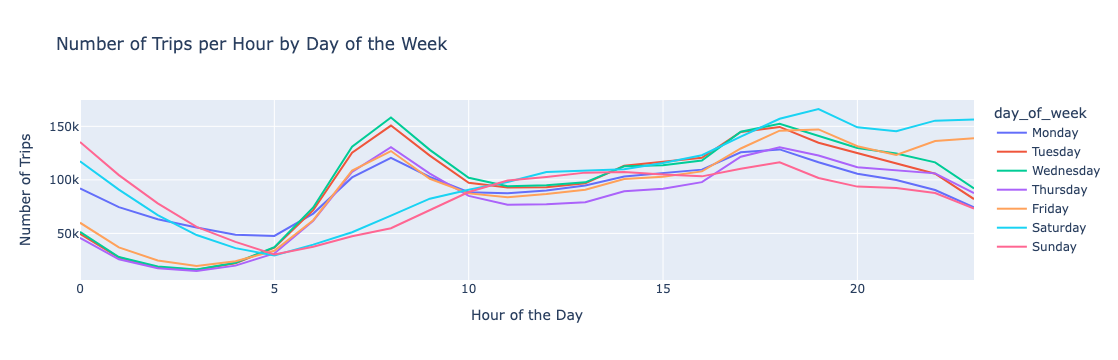

In [16]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

grouped = df.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='trip_count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped['day_of_week'] = pd.Categorical(grouped['day_of_week'], categories=day_order, ordered=True)
grouped = grouped.sort_values(['day_of_week', 'hour_of_day'])

fig = px.line(
    grouped,
    x='hour_of_day',
    y='trip_count',
    color='day_of_week',
    labels={'hour_of_day': 'Hour of the Day', 'trip_count': 'Number of Trips'},
    title='Number of Trips per Hour by Day of the Week'
)
fig.show()


as expected on working days (mon-friday) peak in the morning, lower number of trips during nights
and on sat and sun vice versa

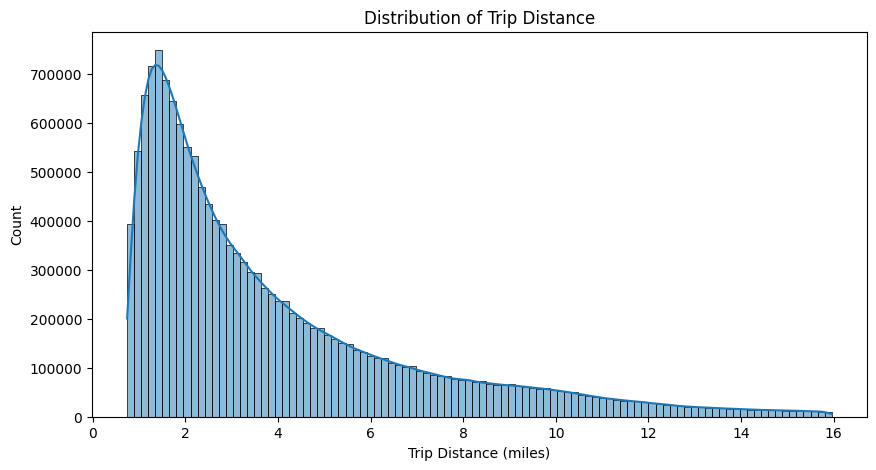

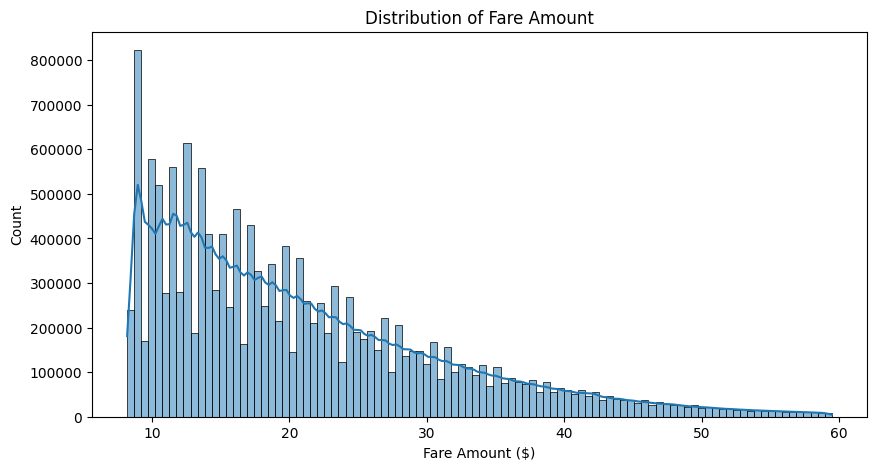

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df['trip_miles'], bins=100, kde=True)
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['base_passenger_fare'], bins=100, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Count')
plt.show()



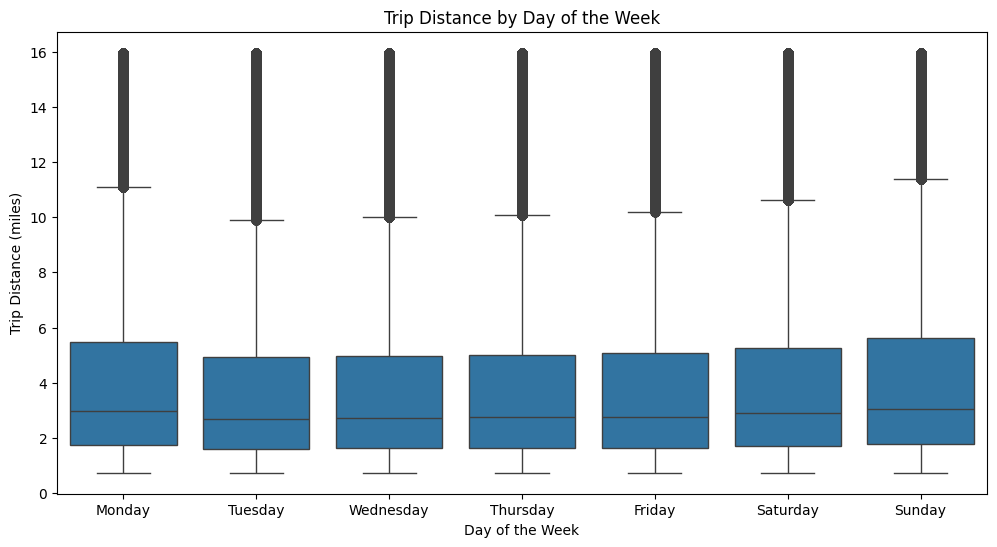

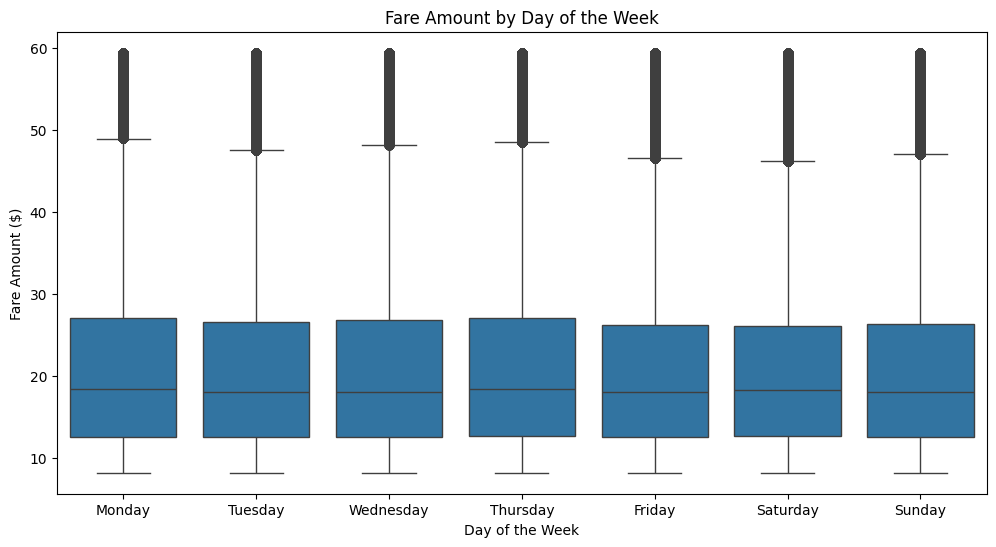

In [18]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='day_of_week', y='trip_miles', order=order)
plt.title('Trip Distance by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Trip Distance (miles)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='day_of_week', y='base_passenger_fare', order=order)
plt.title('Fare Amount by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fare Amount ($)')
plt.show()


In [ ]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
autocorrelation_plot(df['trip_miles'].dropna())
plt.title('Autocorrelation of Trip Distance')
plt.show()

plt.figure(figsize=(10, 4))
autocorrelation_plot(df['base_passenger_fare'].dropna())
plt.title('Autocorrelation of Fare Amount')
plt.show()


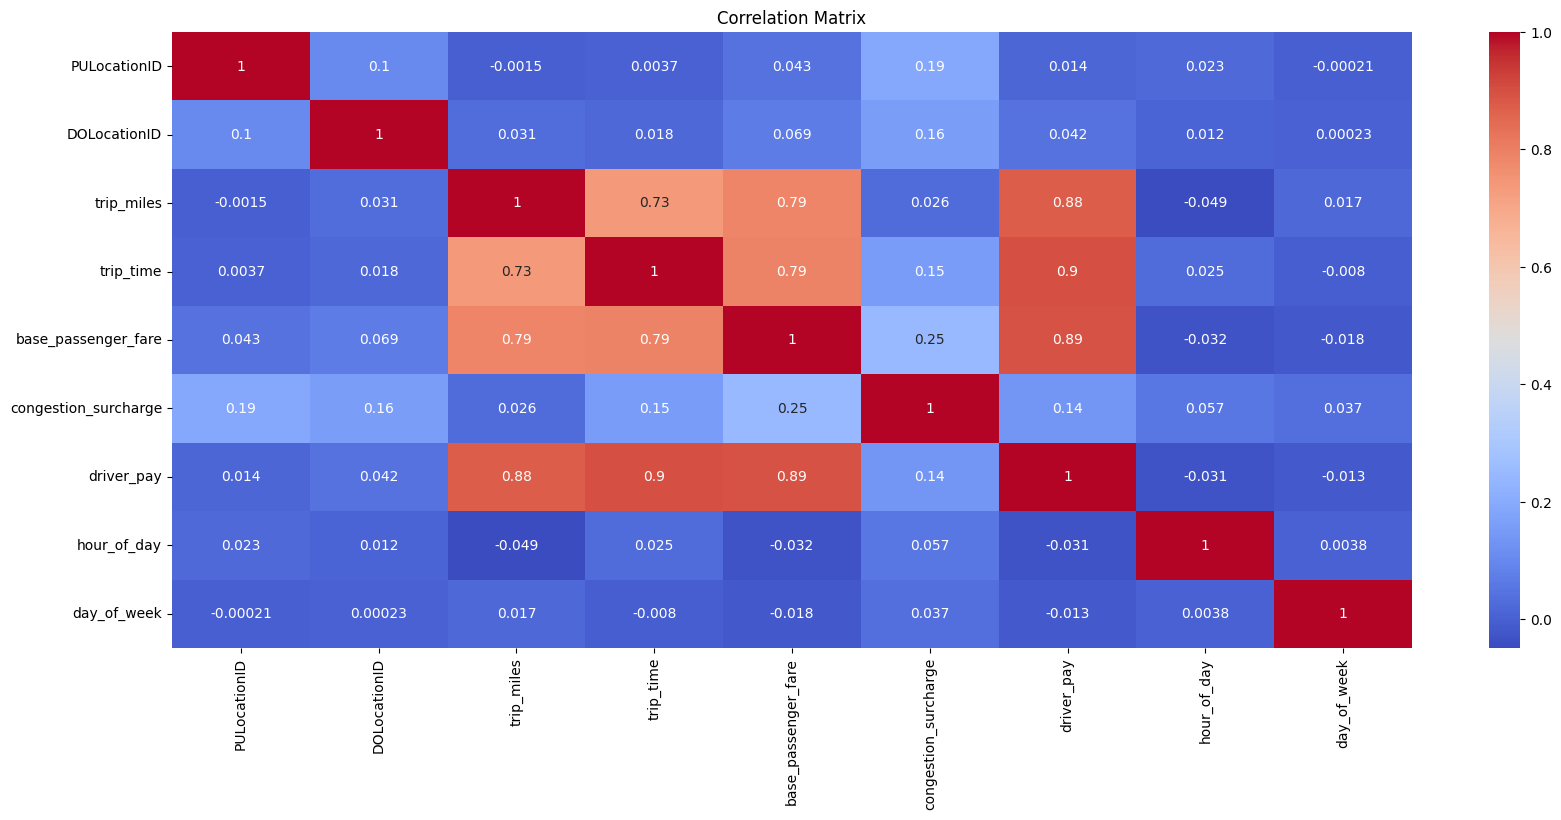

In [26]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

corr = df[['PULocationID', 'DOLocationID', 
           'trip_miles', 'trip_time', 'base_passenger_fare', 
           'congestion_surcharge', 'driver_pay',
           'hour_of_day', 'day_of_week']].corr()

sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True,
            cmap='coolwarm', 
            ax=ax)
plt.title('Correlation Matrix')
plt.show()


In [83]:
def get_trad_df(completed_cars_file, number, co2_per_km=4.8):
    date_range = pd.date_range(
        start="2024-01-01 00:00:00", 
        end="2024-02-01 00:00:00", 
        freq="15min"
    )
    on_line_cars = pd.DataFrame({"agg": date_range})
    on_line_cars["hour"] = on_line_cars["agg"].dt.hour
    on_line_cars["on_line_time"] = on_line_cars["hour"].apply(
    lambda x: 840 * number if (x < 21) and (x >= 6) else 0
    )
    
    trips_table = pd.read_parquet(f'../results/{completed_cars_file}')
    
    trips_table['agg'] = trips_table['request_datetime'].dt.floor('15min')
    trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee'] - trips_table['driver_pay']
    trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']
    
    assigned = trips_table[trips_table['assigned'] == True]
    
    
    metrics = trips_table.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                    .rename(columns={'trip_time': 'time_with_passenger'})
    
    metrics = metrics.merge(on_line_cars, on='agg')
    
    metrics = metrics.merge(trips_table.pivot_table(index='agg', 
                            columns='assigned', 
                            values='trip_id', 
                            aggfunc='count',
                            fill_value=0).reset_index().rename(columns={False:'missed_trips', True:'completed_trips'}),
                          on='agg')
    
    metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']
    metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

    metrics['default'] = 1

    return metrics
    

In [84]:
def get_df_from_files(on_line_cars_files, completed_cars_file, co2_per_km = 0.4):
    on_line_cars = pd.read_parquet(f'../results/{on_line_cars_files}')
    on_line_cars['agg'] = pd.to_datetime(on_line_cars['timestamp']).dt.floor('15min')
    
    trips_table = pd.read_parquet(f'../results/{completed_cars_file}')
    
    trips_table['agg'] = trips_table['request_datetime'].dt.floor('15min')
    trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee'] - trips_table['driver_pay']
    trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']
    
    assigned = trips_table[trips_table['assigned'] == True]
    
    
    metrics = trips_table.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                    .rename(columns={'trip_time': 'time_with_passenger'})
    
    aggregated_on_line_cars = on_line_cars.groupby(['agg', 'car_id'])['timestamp'].agg(['min', 'max'])
    aggregated_on_line_cars['on_line_time'] = (pd.to_datetime(aggregated_on_line_cars['max']) - pd.to_datetime(aggregated_on_line_cars['min']))\
                                .dt.total_seconds()
    metrics = metrics.merge(aggregated_on_line_cars.groupby(['agg'])['on_line_time'].sum().reset_index(), on='agg')
    
    metrics = metrics.merge(trips_table.pivot_table(index='agg', 
                            columns='assigned', 
                            values='trip_id', 
                            aggfunc='count',
                            fill_value=0).reset_index().rename(columns={False:'missed_trips', True:'completed_trips'}),
                          on='agg')
    
    metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']
    metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

    metrics['default'] = 1

    return metrics

In [85]:
saev_100 = get_df_from_files('saev_online_cars_day_100.parquet', 'saev_completed_trips_day_100.parquet')
trad_100 = get_trad_df('trad_completed_trips_day_100.parquet', 100)

In [88]:
trad_100['group'] = 'traditional'
saev_100['group'] = 'saev'

metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }



for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key

    p_value = deltamethod(trad_100[nom], trad_100[den], saev_100[nom], saev_100[den], alternative='two-sided').pvalue
    print(metric_name, round(p_value, 4))

co2_emissions 0.0
net_revenue 0.9992
utilization 0.0
completed_rate 0.0
completed_trips 0.0


In [89]:
saev_500 = get_df_from_files('saev_online_cars_day_500.parquet', 'saev_completed_trips_day_500.parquet')
trad_500 = get_trad_df('trad_completed_trips_day_500.parquet', 500)

trad_500['group'] = 'traditional'
saev_500['group'] = 'saev'

metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }



for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key

    p_value = deltamethod(trad_500[nom], trad_500[den], saev_500[nom], saev_500[den], alternative='two-sided').pvalue
    print(metric_name, round(p_value, 4))

co2_emissions 0.0
net_revenue 0.9962
utilization 0.0
completed_rate 0.0
completed_trips 0.0


In [91]:
saev_3500 = get_df_from_files('saev_online_cars_day_3500.parquet', 'saev_completed_trips_day_3500.parquet')
trad_3500 = get_trad_df('trad_completed_trips_day_3500.parquet', 3500)

trad_3500['group'] = 'traditional'
saev_3500['group'] = 'saev'

metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }



for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key

    p_value = deltamethod(trad_3500[nom], trad_3500[den], saev_3500[nom], saev_3500[den], alternative='two-sided').pvalue
    print(metric_name, round(p_value, 4))

co2_emissions 0.0
net_revenue 0.9588
utilization 0.0
completed_rate 0.0
completed_trips 0.0
